# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import neuro_op as nop
import matplotlib.pyplot as plt

# import networkx as nx
import numpy as np
import scipy.stats as st

In [2]:
input = dict(
    N_nodes=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(500),
    likelihood=st.norm(loc=0, scale=5),
    world_dist=st.norm(loc=0, scale=5),
    h=1,
    r=1,
    t0=0,
    t_max=10000,
    t_sample=250,
    sample_bins=50,
    sample_opinion_range=[-20, 20],
    sample_p_distance_params=[[1, 1], [2, 1]],
    progress=False,
)

output_variables = [
    "nodes",
    "G",
    "beliefs",
    "world",
    "N_events",
    "t_end",
    "mu_nodes",
    "kl_divs",
    "p_distances",
    "RANDOM_SEED",
]

In [14]:
out1 = nop.run_model(**input)

print(f"Number of events: {out1['N_events']}")

/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:253: RuntimeWarning: invalid value encountered in divide
  ppd_world_out = ppd_world_out[0] / np.sum(
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:165: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:165: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


Number of events: 20162


## Data analysis

After simulating the network with $h=1, r=0$ (meaning nodes communicating with the central node only), some simple analysis steps follow.



In [15]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [16]:
 for key, value in out1.items():
    globals()[key] = value


Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


Text(0, 0.5, '$p(\\mu|x_i)$')

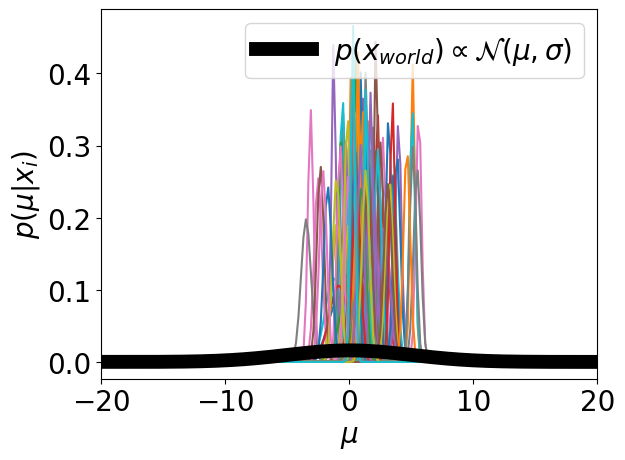

In [18]:
for i in range(len(nodes)):
    plt.plot(nodes[0].beliefs, nop.logpdf_to_pdf(nodes[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(
    beliefs,
    nop.logpdf_to_pdf(world.log_probs),
    color="black",
    linewidth=10,
    label="$p(x_{world}) \propto \mathcal{N}(\mu,\sigma)$",
)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu|x_i)$")

#### Data analysis 2

In [19]:
out1.keys()
kld = np.array(out1["kl_divs"])
lin_dis = np.array(out1["p_distances"])[:, 0]
lin_dis.shape

(41, 2, 100)

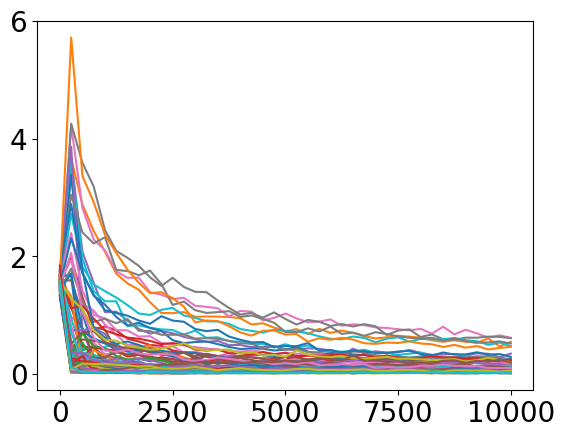

In [20]:
for i in range(input["N_nodes"]):
    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, 1])

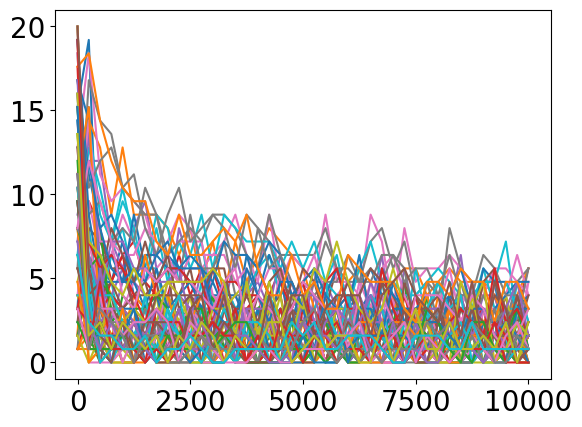

In [21]:
for i in range(input["N_nodes"]):
    plt.plot(input["t_sample"] * np.arange(0, lin_dis.shape[0]), lin_dis[:, 1, i])

In [31]:
arr = np.array(out1["p_distances"])
arr.shape

(41, 2, 2, 100)

In [34]:
arr[:, 0, 0, :]

array([[16.8, 20.8, 10.4, ...,  8.8, 33.6, 26.4],
       [12. ,  2.4,  4.8, ...,  4. ,  1.6,  0.8],
       [ 5.6,  2.4,  0. , ...,  3.2,  2.4,  1.6],
       ...,
       [ 0.8,  2.4,  0.8, ...,  0. ,  2.4,  0.8],
       [ 3.2,  0.8,  1.6, ...,  1.6,  0. ,  0.8],
       [ 0.8,  0.8,  1.6, ...,  0.8,  2.4,  0.8]])